<a href="https://colab.research.google.com/github/msibriani/bigdata_equipo25/blob/main/RS_Avanzado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Avance 2 - Sistema de Recomendación (Avanzado)

- Matthias Sibrian Illescas A01794249
- Johan Andrés Castro Gómez A01793556
- Luis Miguel González Gutiérrez A01794779

En este notebook se presenta el segundo avance del sistema de recomendación. El notebook está dividido en cuatro secciones principales:

1. **Librerías**: Importación de las librerías necesarias.
2. **Lectura de datos**: Carga y preprocesamiento de los datos.
3. **Métricas de evaluación de desempeño**: Se presentan tres métricas para la evaluación del desempeño del sistema de recomendación
4. **Sistema de recomendación Avanzado**: Implementación de un sistema de recomendación Avanzado.
5. **Explicación del sistema de recomedación avanzado**: explicación de la arquitectura del sistema de recomndación

## Librerias

In [ ]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.sparse import csr_matrix

import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping


## Lectura de datos

In [ ]:
#df = pd.read_csv('Datos/RAW_interactions.csv')
df = pd.read_csv('/content/RAW_interactions_compact.csv')
df

,Unnamed: 0,user_id,recipe_id,rating
0,0,38094,40893,4
1,1,1293707,40893,5
2,2,8937,44394,4
3,3,126440,85009,5
4,4,57222,85009,5
...,...,...,...,...
1132362,1132362,116593,72730,0
1132363,1132363,583662,386618,5
1132364,1132364,157126,78003,5
1132365,1132365,53932,78003,4


In [ ]:
reviews_por_usuario = df['user_id'].value_counts()

percentil_99 = reviews_por_usuario.quantile(0.999)
percentil_99

518.4310000000114

In [ ]:
len(reviews_por_usuario[(reviews_por_usuario > 2) & (reviews_por_usuario <= percentil_99)].index)

37349

In [ ]:
filtro_usuarios = reviews_por_usuario[(reviews_por_usuario > 2) & (reviews_por_usuario <= percentil_99)].index

df_filtrado = df[df['user_id'].isin(filtro_usuarios)]
df_filtrado

,Unnamed: 0,user_id,recipe_id,rating
0,0,38094,40893,4
1,1,1293707,40893,5
2,2,8937,44394,4
4,4,57222,85009,5
6,6,124416,120345,0
...,...,...,...,...
1132354,1132354,143592,82303,5
1132356,1132356,199020,82303,5
1132357,1132357,1122988,82303,5
1132361,1132361,102526,54493,0


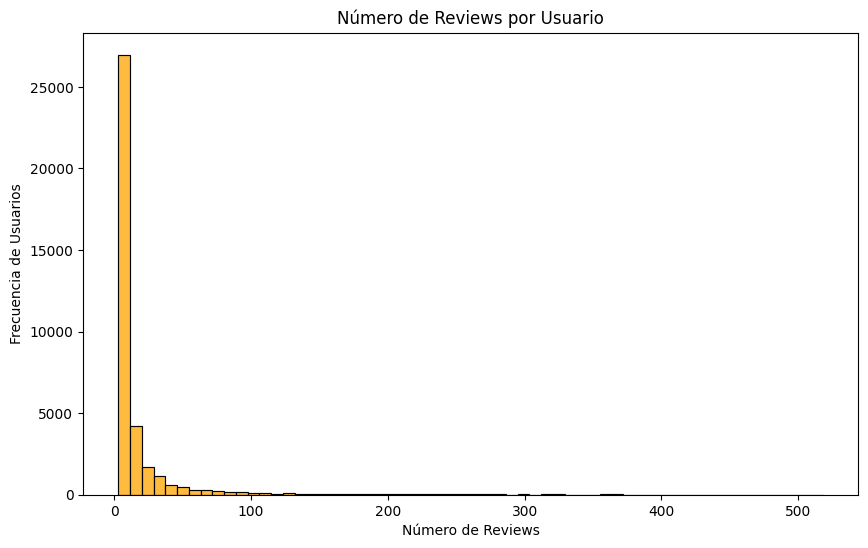

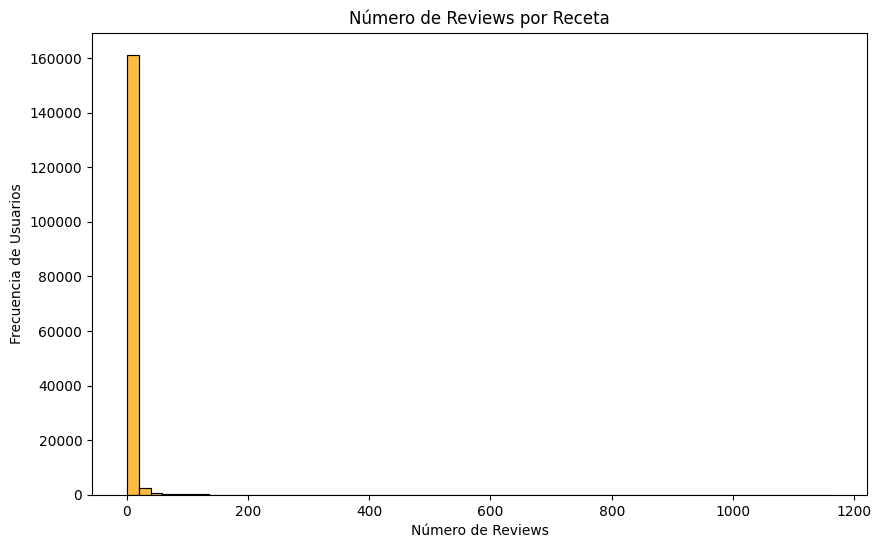

In [ ]:
reviews_por_usuario = df_filtrado['user_id'].value_counts()
reviews_por_receta = df_filtrado['recipe_id'].value_counts()

plt.figure(figsize=(10, 6))
sns.histplot(reviews_por_usuario, kde=False, bins=60, color='orange')
plt.title('Número de Reviews por Usuario')
plt.xlabel('Número de Reviews')
plt.ylabel('Frecuencia de Usuarios')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(reviews_por_receta, kde=False, bins=60, color='orange')
plt.title('Número de Reviews por Receta')
plt.xlabel('Número de Reviews')
plt.ylabel('Frecuencia de Usuarios')
plt.show()

En el análisis exploratorio realizado en la entrega anterior, se identificaron algunos usuarios con un número inusualmente alto de reseñas. Estos usuarios fueron filtrados para la creación del sistema de recomendación avanzado, con el objetivo de mejorar la precisión y la relevancia de las recomendaciones. Además, se filtraron los usuarios con dos o menos reseñas para evitar el problema conocido como "cool start", que ocurre cuando hay poca información disponible sobre un usuario, dificultando la generación de recomendaciones precisas.

En futuras entregas, se explorarán otros tipos de sistemas de recomendación para abordar estos casos de usuarios con pocas reseñas. Una de las alternativas que se considerará es un sistema de recomendación basado en contenido, el cual utiliza las características de los ítems y las preferencias explícitas de los usuarios para generar recomendaciones personalizadas. Este enfoque puede ser especialmente útil para nuevos usuarios o aquellos con poca actividad en la plataforma, proporcionando una solución eficaz al problema del "cool start".

## Métricas de evaluación de desempeño

In [ ]:
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)

    return mse, rmse, mae

Para evaluar el desempeño de los sistemas de recomendación, se escogió usar tres métricas relevantes para métodos de regresión: Mean Absolute Error (MAE), Root Mean Square Error (RMSE) y Mean Squared Error (MSE), y cómo se pueden aplicar en nuestro proyecto de sistema de recomendación.

## 1. Mean Absolute Error (MAE)

**Identificación:**
- MAE mide el promedio de los errores absolutos entre las predicciones del sistema de recomendación y los valores reales.

**Justificación:**
- MAE es fácil de entender e interpretar, ya que mide el error promedio en las mismas unidades que los datos originales. Además, no penaliza fuertemente los errores grandes, lo que lo hace menos sensible a los outliers. Usarlo proporcionará una medida directa del error promedio en las calificaciones predichas, ayudando a entender la precisión general del sistema.

## 2. Root Mean Square Error (RMSE)

**Identificación:**
- RMSE mide la raíz cuadrada de la media de los errores al cuadrado entre las predicciones y los valores reales.

**Justificación:**
RMSE penaliza más los errores grandes debido al cuadrado de las diferencias. Esto puede ser útil en sistemas de recomendación donde es importante minimizar grandes discrepancias. Usarlo permitirá identificar si hay errores grandes en las predicciones que necesitan ser corregidos, asegurando que las recomendaciones sean más fiables y precisas.

## 3. Mean Squared Error (MSE)

**Identificación:**
- MSE calcula el promedio de los errores al cuadrado entre las predicciones y los valores reales.

**Justificación:**
- MSE es una métrica que es fácil de manejar matemáticamente, especialmente en el contexto de optimización de modelos. Además, al ser la base para el cálculo de RMSE, proporciona una vista adicional del error y es útil para comprender la varianza del error. Este servirá para comprender la dispersión de los errores en el sistema de recomendación.

## Sistema de recomendación Avanzado (Experimentos)

In [ ]:
# Mapear los ID de usuarios a índices secuenciales
usuario_ids = df_filtrado['user_id'].unique()
mapa_usuario_ids = {id: idx for idx, id in enumerate(usuario_ids)}
df_filtrado['usuario_idx'] = df_filtrado['user_id'].map(mapa_usuario_ids)

# Mapear los ID de recetas a índices secuenciales
receta_ids = df_filtrado['recipe_id'].unique()
mapa_receta_ids = {id: idx for idx, id in enumerate(receta_ids)}
df_filtrado['receta_idx'] = df_filtrado['recipe_id'].map(mapa_receta_ids)

print("DataFrame con índices mapeados:")
df_filtrado

<ipython-input-8-05e2a022287e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado['usuario_idx'] = df_filtrado['user_id'].map(mapa_usuario_ids)


DataFrame con índices mapeados:


<ipython-input-8-05e2a022287e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado['receta_idx'] = df_filtrado['recipe_id'].map(mapa_receta_ids)


,Unnamed: 0,user_id,recipe_id,rating,usuario_idx,receta_idx
0,0,38094,40893,4,0,0
1,1,1293707,40893,5,1,0
2,2,8937,44394,4,2,1
4,4,57222,85009,5,3,2
6,6,124416,120345,0,4,3
...,...,...,...,...,...,...
1132354,1132354,143592,82303,5,30356,165235
1132356,1132356,199020,82303,5,2396,165235
1132357,1132357,1122988,82303,5,210,165235
1132361,1132361,102526,54493,0,3032,165256


In [ ]:
# Crear las etiquetas de rating
X = df_filtrado[['usuario_idx', 'receta_idx']]
y = df_filtrado['rating']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Parámetros de entrada
num_users = df_filtrado['usuario_idx'].nunique()
num_items = df_filtrado['receta_idx'].nunique()
embedding_dim = 50

# Entrada del usuario e ítem
user_input = Input(shape=(1,), name='user_input')
item_input = Input(shape=(1,), name='item_input')

# Embeddings para usuarios e ítems
user_embedding = Embedding(input_dim=num_users, output_dim=embedding_dim, name='user_embedding')(user_input)
item_embedding = Embedding(input_dim=num_items, output_dim=embedding_dim, name='item_embedding')(item_input)

# Flatten the embeddings
user_flat = Flatten()(user_embedding)
item_flat = Flatten()(item_embedding)

# Concatenate embeddings
concat = Concatenate()([user_flat, item_flat])

# Red neuronal densa
fc1 = Dense(128, activation='relu')(concat)
fc2 = Dense(64, activation='relu')(fc1)
output = Dense(1)(fc2)

# Compilar el modelo
model_ncf = Model(inputs=[user_input, item_input], outputs=output)
model_ncf.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

# Resumen del modelo
model_ncf.summary()

# Entrenar el modelo
history = model_ncf.fit([X_train['usuario_idx'], X_train['receta_idx']], y_train, epochs=10, batch_size=64, validation_split=0.2)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 item_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 user_embedding (Embedding)  (None, 1, 50)                1867450   ['user_input[0][0]']          
                                                                                                  
 item_embedding (Embedding)  (None, 1, 50)                8264500   ['item_input[0][0]']          
                                                                                              

In [ ]:
# Evaluar NCF
y_pred_ncf = model_ncf.predict([X_test['usuario_idx'], X_test['receta_idx']])
mse_ncf, rmse_ncf, mae_ncf = evaluate_model(y_test, y_pred_ncf)

print(f"MSE: {mse_ncf}, RMSE: {rmse_ncf}, MAE: {mae_ncf}")


4070/4070 [==============================] - 9s 2ms/step
MSE: 1.4198412913010667, RMSE: 1.1915709342297112, MAE: 0.7136218072974675


In [ ]:
# Crear las etiquetas de rating
X = df_filtrado[['usuario_idx', 'receta_idx']]
y = df_filtrado['rating']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Parámetros de entrada
num_users = df_filtrado['usuario_idx'].nunique()
num_items = df_filtrado['receta_idx'].nunique()
embedding_dim = 20

# Entrada del usuario e ítem
user_input = Input(shape=(1,), name='user_input')
item_input = Input(shape=(1,), name='item_input')

# Embeddings para usuarios e ítems
user_embedding = Embedding(input_dim=num_users, output_dim=embedding_dim, name='user_embedding')(user_input)
item_embedding = Embedding(input_dim=num_items, output_dim=embedding_dim, name='item_embedding')(item_input)

# Flatten the embeddings
user_flat = Flatten()(user_embedding)
item_flat = Flatten()(item_embedding)

# Concatenate embeddings
concat = Concatenate()([user_flat, item_flat])

# Red neuronal densa con regularización y dropout
fc1 = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(concat)
fc1 = Dropout(0.5)(fc1)
fc2 = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(fc1)
fc2 = Dropout(0.5)(fc2)
output = Dense(1)(fc2)

# Compilar el modelo
model_ncf = Model(inputs=[user_input, item_input], outputs=output)
model_ncf.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entrenar el modelo
history = model_ncf.fit(
    [X_train['usuario_idx'], X_train['receta_idx']], y_train,
    epochs=20, batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping]
)

# Evaluación del modelo
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)

    return mse, rmse, mae

# Evaluar NCF
y_pred_ncf = model_ncf.predict([X_test['usuario_idx'], X_test['receta_idx']])
mse_ncf, rmse_ncf, mae_ncf = evaluate_model(y_test, y_pred_ncf)

print(f"MSE: {mse_ncf}, RMSE: {rmse_ncf}, MAE: {mae_ncf}")

Epoch 1/20
6512/6512 [==============================] - 43s 6ms/step - loss: 1.7690 - mse: 1.7314 - val_loss: 1.1397 - val_mse: 1.1328
Epoch 2/20
6512/6512 [==============================] - 37s 6ms/step - loss: 1.1267 - mse: 1.1165 - val_loss: 1.1316 - val_mse: 1.1223
Epoch 3/20
6512/6512 [==============================] - 36s 6ms/step - loss: 0.9949 - mse: 0.9846 - val_loss: 1.1496 - val_mse: 1.1402
Epoch 4/20
6512/6512 [==============================] - 36s 6ms/step - loss: 0.9402 - mse: 0.9304 - val_loss: 1.1850 - val_mse: 1.1759
Epoch 5/20
4070/4070 [==============================] - 8s 2ms/step
MSE: 1.1448038665702842, RMSE: 1.0699550768935508, MAE: 0.6489181857730013


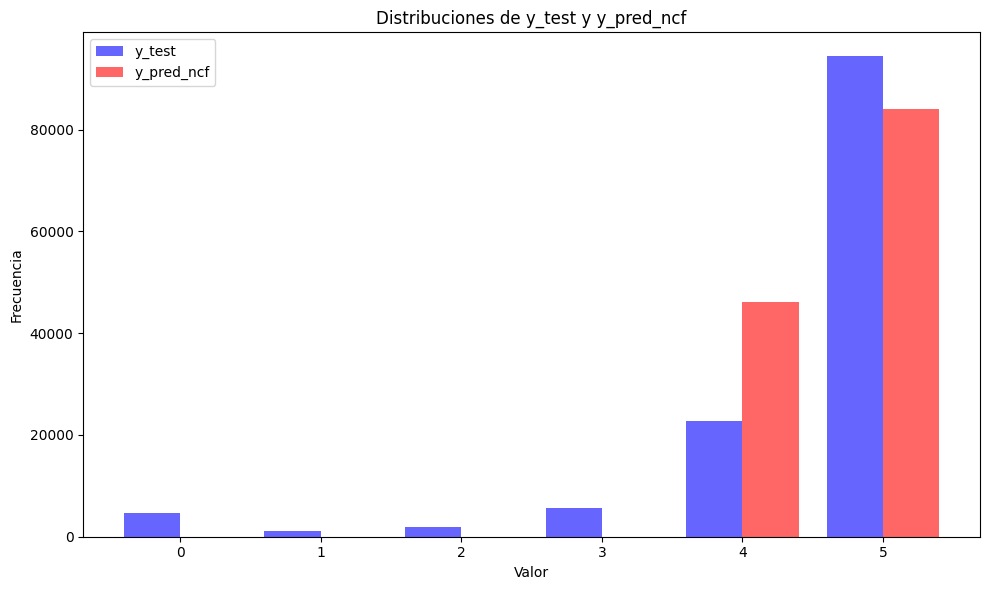

In [ ]:
# Definir los bins
bins = np.arange(0, 7)  # Ajustar según el rango de los datos

# Calcular las frecuencias
y_test_hist, _ = np.histogram(y_test, bins=bins)
y_pred_hist, _ = np.histogram(np.round(y_pred_ncf), bins=bins)

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(10, 6))

# Crear el gráfico de barras comparativo
bar_width = 0.4
ax.bar(bins[:-1] - bar_width/2, y_test_hist, bar_width, label='y_test', alpha=0.6, color='blue', align='center')
ax.bar(bins[:-1] + bar_width/2, y_pred_hist, bar_width, label='y_pred_ncf', alpha=0.6, color='red', align='center')

# Añadir etiquetas y título
ax.set_xlabel('Valor')
ax.set_ylabel('Frecuencia')
ax.set_title('Distribuciones de y_test y y_pred_ncf')
ax.legend()

# Ajustar el layout para que los subplots no se solapen
plt.tight_layout()
plt.show()


Epoch 1/20
6512/6512 [==============================] - 40s 6ms/step - loss: 0.1727 - mse: 0.1625 - val_loss: 0.1200 - val_mse: 0.1190
Epoch 2/20
6512/6512 [==============================] - 37s 6ms/step - loss: 0.1166 - mse: 0.1148 - val_loss: 0.1186 - val_mse: 0.1172
Epoch 3/20
6512/6512 [==============================] - 37s 6ms/step - loss: 0.1074 - mse: 0.1053 - val_loss: 0.1216 - val_mse: 0.1198
Epoch 4/20
6512/6512 [==============================] - 36s 5ms/step - loss: 0.1020 - mse: 0.0999 - val_loss: 0.1245 - val_mse: 0.1226
Epoch 5/20
4070/4070 [==============================] - 7s 2ms/step
MSE: 0.11996171571165112, RMSE: 0.3463548984952445, MAE: 0.17080166258575255


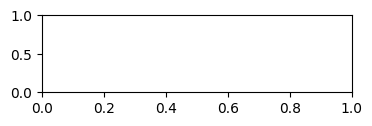

In [ ]:
# Crear las etiquetas de rating
X = df_filtrado[['usuario_idx', 'receta_idx']]
y = df_filtrado['rating']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train = np.log(y_train+1)
y_test = np.log(y_test+1)

# Parámetros de entrada
num_users = df_filtrado['usuario_idx'].nunique()
num_items = df_filtrado['receta_idx'].nunique()
embedding_dim = 20

# Entrada del usuario e ítem
user_input = Input(shape=(1,), name='user_input')
item_input = Input(shape=(1,), name='item_input')

# Embeddings para usuarios e ítems
user_embedding = Embedding(input_dim=num_users, output_dim=embedding_dim, name='user_embedding')(user_input)
item_embedding = Embedding(input_dim=num_items, output_dim=embedding_dim, name='item_embedding')(item_input)

# Flatten the embeddings
user_flat = Flatten()(user_embedding)
item_flat = Flatten()(item_embedding)

# Concatenate embeddings
concat = Concatenate()([user_flat, item_flat])

# Red neuronal densa con regularización y dropout
fc1 = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(concat)
fc1 = Dropout(0.5)(fc1)
fc2 = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(fc1)
fc2 = Dropout(0.5)(fc2)
output = Dense(1)(fc2)

# Compilar el modelo
model_ncf_log = Model(inputs=[user_input, item_input], outputs=output)
model_ncf_log.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entrenar el modelo
history = model_ncf_log.fit(
    [X_train['usuario_idx'], X_train['receta_idx']], y_train,
    epochs=20, batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping]
)

# Evaluación del modelo
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)

    return mse, rmse, mae

# Evaluar NCF
y_pred_ncf = model_ncf_log.predict([X_test['usuario_idx'], X_test['receta_idx']])
mse_ncf, rmse_ncf, mae_ncf = evaluate_model(y_test, y_pred_ncf)

print(f"MSE: {mse_ncf}, RMSE: {rmse_ncf}, MAE: {mae_ncf}")

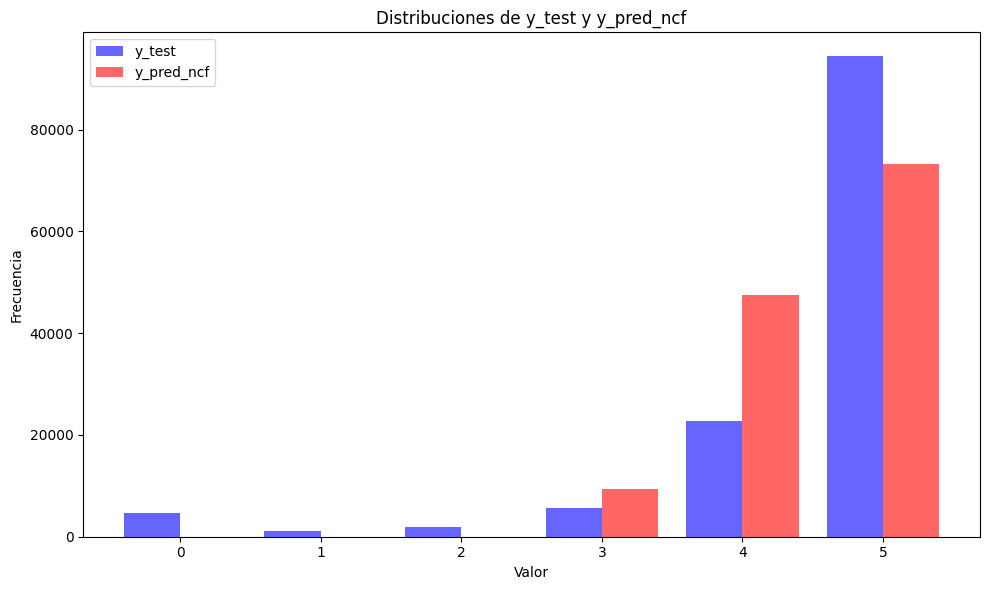

In [ ]:
# Definir los bins
bins = np.arange(0, 7)  # Ajustar según el rango de los datos

# Calcular las frecuencias
y_test_hist, _ = np.histogram(np.round(np.exp(y_test)-1), bins=bins)
y_pred_hist, _ = np.histogram(np.round(np.exp(y_pred_ncf)-1), bins=bins)

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(10, 6))

# Crear el gráfico de barras comparativo
bar_width = 0.4
ax.bar(bins[:-1] - bar_width/2, y_test_hist, bar_width, label='y_test', alpha=0.6, color='blue', align='center')
ax.bar(bins[:-1] + bar_width/2, y_pred_hist, bar_width, label='y_pred_ncf', alpha=0.6, color='red', align='center')

# Añadir etiquetas y título
ax.set_xlabel('Valor')
ax.set_ylabel('Frecuencia')
ax.set_title('Distribuciones de y_test y y_pred_ncf')
ax.legend()

# Ajustar el layout para que los subplots no se solapen
plt.tight_layout()
plt.show()

In [ ]:
# Guardar el modelo entrenado
model_ncf_log.save('ncf_model_log.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
mapa_receta_ids_inv = {value: key for key, value in mapa_receta_ids.items()}

def top_k_recomendaciones(user_id, k=10):
    # Obtener el índice del usuario
    user_idx = mapa_usuario_ids[user_id]

    # Crear un array con todos los índices de recetas
    all_recipe_indices = np.arange(num_items)

    # Predecir los ratings para todas las recetas para este usuario
    user_indices = np.full(len(all_recipe_indices), user_idx)
    predicted_ratings = model_ncf_log.predict([user_indices, all_recipe_indices], verbose=0)

    # Obtener los índices de las k mejores recetas
    top_k_indices = np.argsort(predicted_ratings[:, 0])[-k:]

    # Convertir los índices de recetas a IDs de recetas
    top_k_recipe_ids = [mapa_receta_ids_inv[i] for i in top_k_indices]

    plt.figure(figsize=(10, 6))
    sns.histplot(np.exp(predicted_ratings)-1, kde=False, bins=60, color='orange')
    plt.title('Número de Reviews por Receta')
    plt.xlabel('Número de Reviews')
    plt.ylabel('Frecuencia de Usuarios')
    plt.show()

    return top_k_recipe_ids

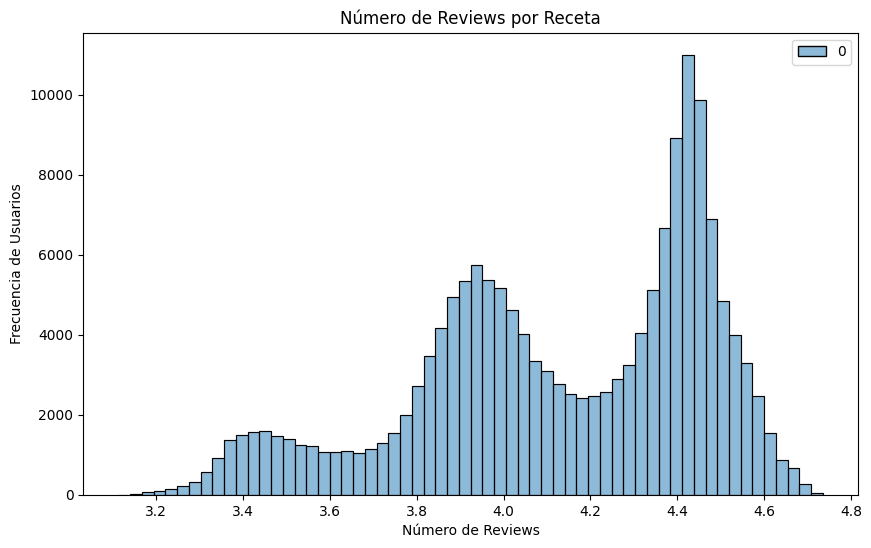

[17764,
 57299,
 104975,
 99918,
 177558,
 113697,
 230035,
 52272,
 79595,
 143043,
 16037,
 74730,
 96392,
 17382,
 160384,
 29569,
 74086,
 56276,
 20374,
 73973,
 486261,
 169388,
 26901,
 53909,
 186029,
 29084,
 71933,
 54266,
 162425,
 244193]

In [ ]:
top_k_recomendaciones(198520, 30)

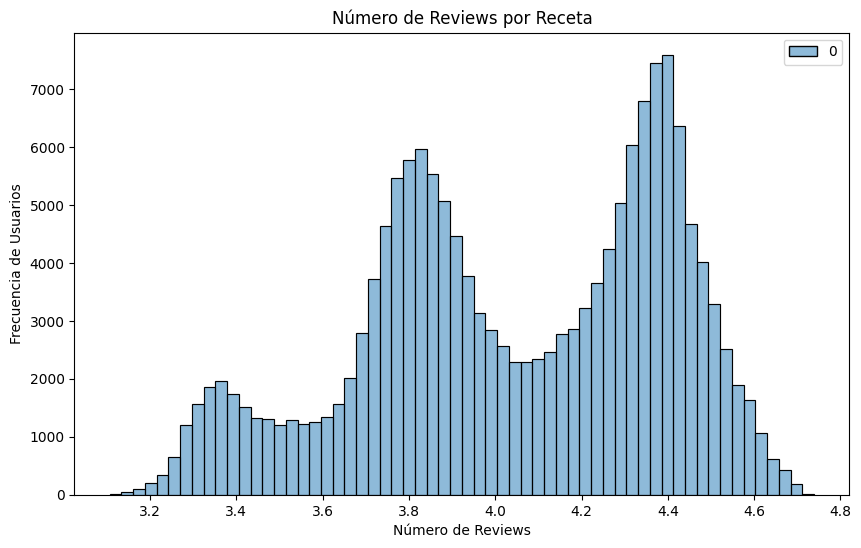

[57299,
 104975,
 17764,
 99918,
 177558,
 113697,
 52272,
 230035,
 79595,
 16037,
 74730,
 96392,
 17382,
 160384,
 29569,
 74086,
 143043,
 56276,
 20374,
 73973,
 486261,
 169388,
 26901,
 53909,
 186029,
 71933,
 29084,
 54266,
 162425,
 244193]

In [ ]:
top_k_recomendaciones(8937, 30)

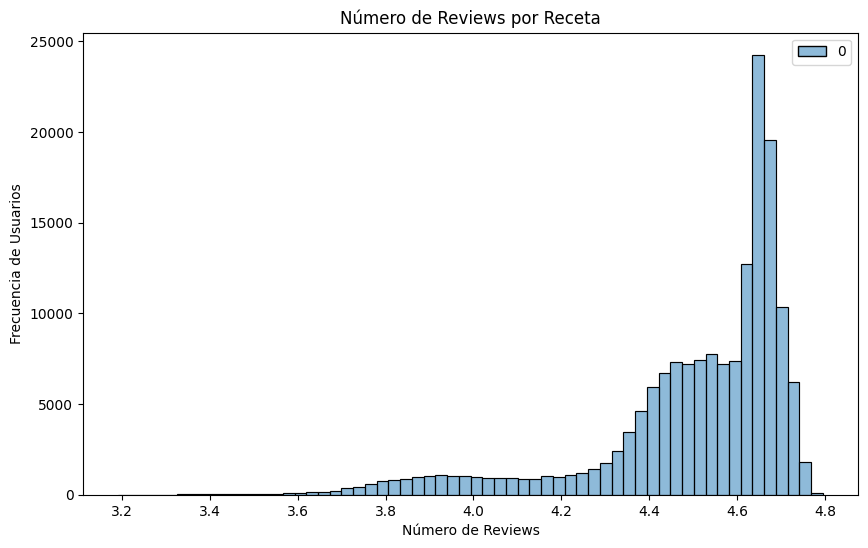

[17382,
 177558,
 104975,
 72654,
 113697,
 51524,
 57299,
 79595,
 53950,
 78274,
 56276,
 20374,
 77497,
 52272,
 160384,
 99918,
 74086,
 74730,
 16037,
 26901,
 486261,
 53909,
 169388,
 73973,
 186029,
 29084,
 71933,
 54266,
 162425,
 244193]

In [ ]:
top_k_recomendaciones(143592, 30)

**Conclusiones de experimentos**

Se realizaron tres experimentos con la arquitectura del sistema de recomendación propuesto, obteniendo resultados significativos en cada uno de ellos:

**Primer experimento:**
En el primer experimento, se observó que el modelo sufría de sobreajuste. Esto se evidenció porque las métricas de entrenamiento mejoraban constantemente, mientras que las métricas de validación empeoraban progresivamente. Este comportamiento indicaba que el modelo estaba aprendiendo demasiado bien los detalles y el ruido de los datos de entrenamiento, perdiendo capacidad de generalización para datos no vistos.

**Segundo experimento:**
Para abordar el problema del sobreajuste identificado en el primer experimento, se introdujeron técnicas adicionales en el segundo experimento, tales como la implementación de capas de dropout y la reducción de la dimensión de la capa de embeddings. Estas modificaciones ayudaron a mitigar el sobreajuste; sin embargo, los resultados mostraron que el modelo todavía tenía dificultades para predecir correctamente los ratings más bajos (0, 1, 2 y 3).

**Tercer experimento:**
En el tercer experimento, se mantuvieron las técnicas aplicadas anteriormente para combatir el sobreajuste y, además, se introdujo una transformación logarítmica en los ratings. Esta transformación tenía como objetivo mejorar la predicción de los ratings bajos. Los resultados de este experimento fueron prometedores, ya que se observó una mejora significativa en la precisión de la predicción de los ratings más bajos tras aplicar la transformación logarítmica.

**Conclusiones finales:**
Los experimentos sugieren que el modelo podría funcionar de manera más eficiente en un escenario con una matriz de datos menos dispersa. Para futuras investigaciones, se recomienda explorar técnicas avanzadas de recomendación basadas en contenido, especialmente útiles en situaciones de "cold start" y en matrices dispersas. Estas técnicas pueden ofrecer mejores resultados al proporcionar recomendaciones más precisas y relevantes, mejorando así la experiencia del usuario.


## Descripción del sistema de recomendación avanzado elegido (Neural Collaborative Filtering)

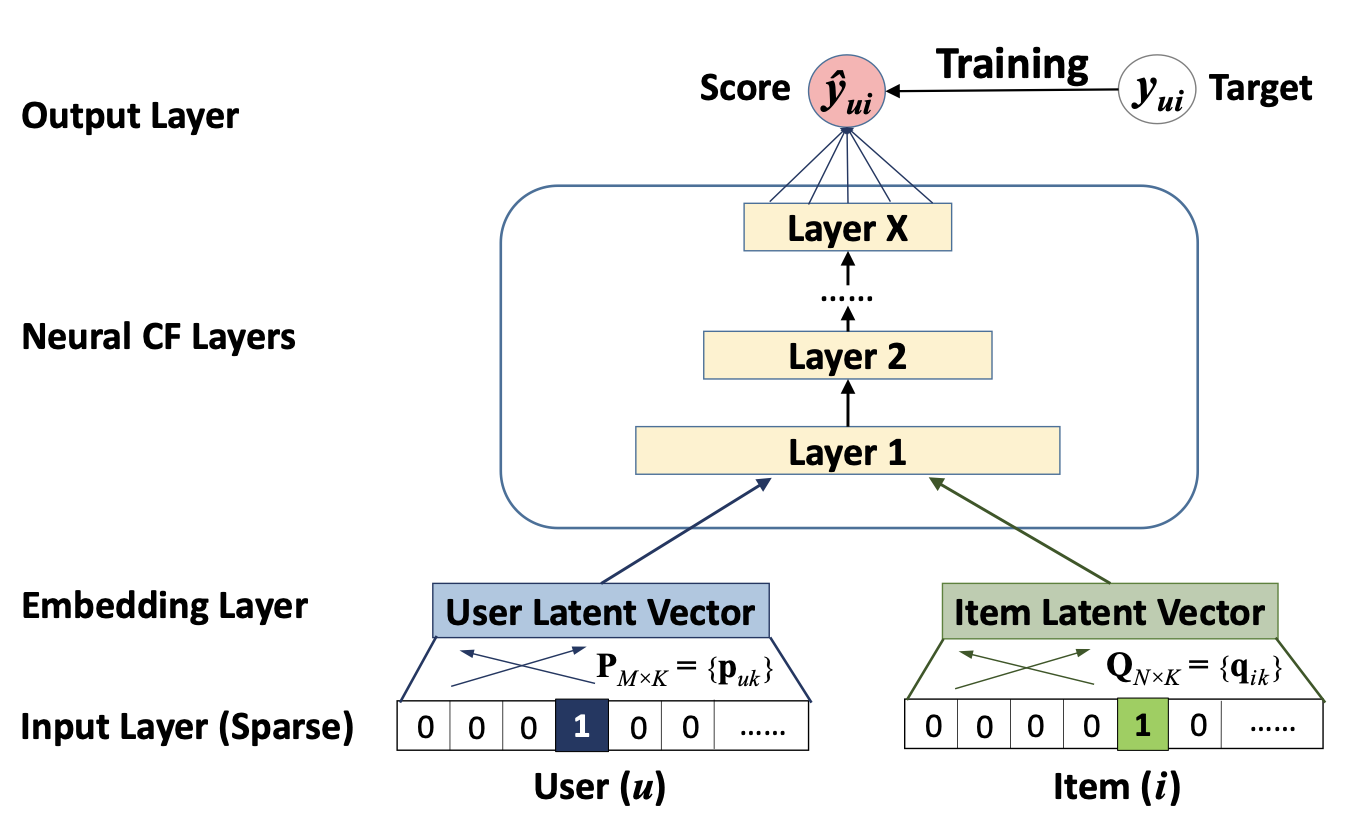


Neural Collaborative Filtering (NCF) es un enfoque avanzado para sistemas de recomendación que utiliza redes neuronales profundas para modelar las interacciones entre usuarios y elementos. A diferencia de los métodos tradicionales que asumen relaciones lineales, NCF puede capturar interacciones no lineales y complejas, mejorando así la precisión de las recomendaciones.

Una de sus principales características es el uso de embeddings para representar tanto a los usuarios como a los elementos. Estos embeddings son vectores densos que se ajustan durante el entrenamiento para minimizar el error de predicción, lo que permite capturar similitudes y diferencias de manera eficiente.

Su arquitectura consiste en varias capas densas que transforman las entradas de embeddings a través de funciones de activación no lineales, como ReLU. Esto permite que el modelo aprenda representaciones jerárquicas de las interacciones, capturando patrones complejos en los datos.

El entrenamiento del modelo se realiza mediante algoritmos de optimización basados en descenso de gradiente, como Adam, el que se está usando actualmente. Estos algoritmos ajustan los parámetros de la red para minimizar una función de pérdida, mejorando el rendimiento del modelo en términos de tiempo de entrenamiento y precisión.

Finalmente, este algoritmo es flexible y escalable, lo que permite adaptar el modelo a diferentes tipos de datos y estructuras de red, y manejar grandes volúmenes de datos. Esta flexibilidad y escalabilidad le permiten ser útil para diversos dominios y aplicaciones.

**Referencia**
He, X., Liao, L., Zhang, H., Nie, L., Hu, X. y Chua, T. (2017). Neural collaborative filtering. In Proceedings of the 26th International Conference on World Wide Web. Disponible en https://arxiv.org/pdf/1708.05031.